In [ ]:
# Import Statements
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from PIL import Image
import umap
import random
import seaborn as sns
from sklearn.preprocessing import normalize

In [12]:
# Device
# GPU useage test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [13]:
# Model: single-layer feature extraction
class ResNet50SingleLayer(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Keep all layers up to avgpool exactly as in base
        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            base.layer2,
            base.layer3,
            base.layer4,
            base.avgpool,  
        )

        for p in self.parameters():
            p.requires_grad = False
        self.eval()

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)   # output shape: (batch, 2048)

In [14]:
# Instantiate model
model = ResNet50SingleLayer().to(device).eval()

# Extract embeddings (single layer only)
embeds = []
hash_order = []

with torch.no_grad():
    for hids, imgs in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(device, non_blocking=True)
        emb = model(imgs)                # shape (B, C)
        embeds.append(emb.cpu().numpy())
        hash_order.extend(hids)

embeds = np.vstack(embeds)
print("Embeddings shape:", embeds.shape)

Extracting embeddings: 100%|██████████| 776/776 [12:11<00:00,  1.06it/s]


Embeddings shape: (49633, 2048)


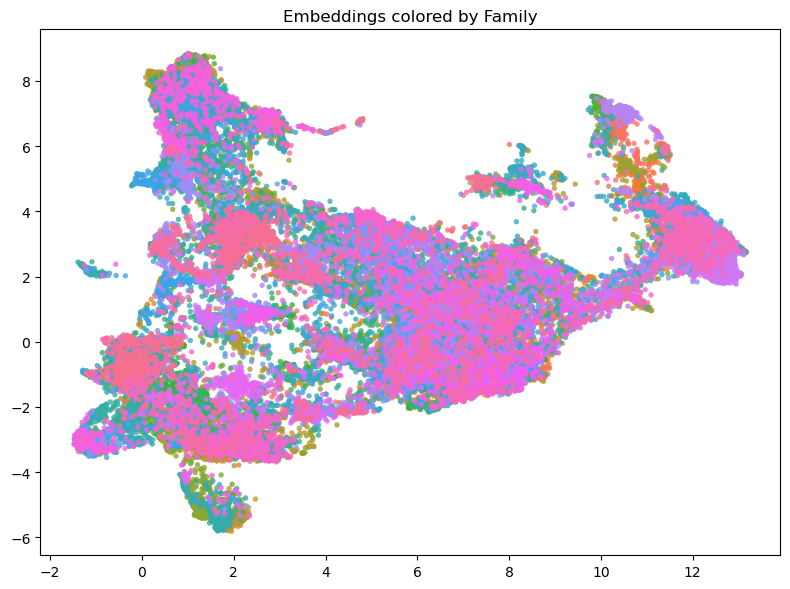

In [33]:
# Normalize to unit length for kmeans stability
X = embeds.astype(np.float32)
X = normalize(X, axis=1)
# UMAP visualizations
reduced = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=seed)
X_2d = reducer.fit_transform(X)

def plot_umap(coords, labels, title, show_legend=False):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=labels, s=15, linewidth=0, alpha=0.8, legend='brief' if show_legend else False)
    plt.title(title)
    if not show_legend:
        plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()

plot_umap(X_2d, df_meta['family'], "Embeddings colored by Family")